# CS146 Week 11 Assignment - Simplified Kalman Filter

Professor Carl Scheffler

2017-11-16

This submission begins with the code generating the message updates, then some graphs and examples of it working on the data we used in class, and then on data with some of the the output values masked. Afterwards, an appendix containing closed-form mathematical derivations of the messages is included. 

This notebook is also available on my GitHub at

https://github.com/guydav/minerva/blob/master/notebooks/CS146/11.X%20Simplified%20Kalman%20Filter.ipynb, 

and the overleaf project containing the mathematical derivations is at 

https://www.overleaf.com/read/nxngwgwsykqp

In [1]:
%matplotlib inline

In [31]:
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn
import sklearn.linear_model
from datetime import datetime, date
from sklearn_pandas import DataFrameMapper
import warnings
import timeit
from collections import defaultdict, OrderedDict
import tabulate
import time
import GPy
from IPython.display import display
import scipy
from scipy import stats

timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
"""

matplotlib.style.use('ggplot')

RANDOM_SEED = 33

## General Strategy:

<img src="kalman_filter_factor_graph.png" alt="Factor graph" style="width: 800px; align: left"/>

* Trivially derive the messages from  $\mu_{f_{y_i} \rightarrow x_i}$
* Sweep forwards in time, deriving the messages $\mu_{f_{x_i} \rightarrow x_i}$ and $\mu_{x_i \rightarrow f_{x_{i+1}}}$ 
* Sweep backwards in time, deriving the messages $\mu_{x_{i+1} \rightarrow f_{x_{i+1}}}$ and $\mu_{f_{x_{i+1}} \rightarrow x_i}$
* Use these messages to derive the marginals over $x_i$ and $y_i$
* Plot graphs of both sets of marginals
* ...
* Profit!

In [89]:
DEFAULT_ALPHA = 0.95


class UnityMessage:
    def __int__(self):
        return 1
    
    def __mul__(self, other):
        # Product of unity message with other message is always other message
        return other
    
    def __call__(self, other):
        # Integrating a product of a unity message only makes sense 
        # if the other message is Gaussian:
        if type(other) == GaussianMessage:
            # And in this case, the integration over the Gaussian comes out to unity:
            return self
        
        raise ValueError('Cannot integrate product of unity messages')
    
    def __repr__(self):
        return '(1)'

    
class GaussianMessage:
    def __init__(self, variable, mean, var):
        # Variable can be either a string (denoting a variable) 
        # or a number (denoting a value)
        self.variable = variable
        self.mean = mean
        self.var = var
        
    def __mul__(self, other):
        # product with unity is this:
        if type(other) == UnityMessage:
            return self
        
        # Assume that when I take a product I always drop the independent factor
        if self.variable != other.variable:
            err = 'Taking product of Gaussians with different variables: {v1}, {v2}'.format(
                v1=self.variable, v2=other.variable)
            raise ValueError(err)
        
        product_mean = (self.mean * other.var + other.mean * self.var) / \
            (self.var + other.var)
        product_var = (self.var * other.var) / (self.var + other.var)
        return GaussianMessage(self.variable, product_mean, product_var)
         
    def __call__(self, other):
        # Use the call overloading to denote 'integrate the product of self and other'
        if type(other) == UnityMessage:
            return other
        
        if self.variable != other.variable:
            err = 'Taking integral of product of Gaussians with different variables: {v1}, {v2}'.format(
                v1=self.variable, v2=other.variable)
            raise ValueError(err)
        
        if not ((type(self.mean) == str) ^ (type(other.mean) == str)):
            raise ValueError('When taking integral, expected exactly one mean to be a variable (string)')
            
        if type(self.mean) == str:
            return GaussianMessage(self.mean, other.mean, self.var + other.var)
        
        return GaussianMessage(other.mean, self.mean, self.var + other.var)
    
    def __repr__(self):
        if type(self.mean) == str:
            return 'N({x} | {mean}, {var:.2f})'.format(x=self.variable, 
                                                       mean=self.mean, 
                                                       var=self.var)
        
        return 'N({x} | {mean:.2f}, {var:.2f})'.format(x=self.variable, 
                                                       mean=self.mean, 
                                                       var=self.var)
    
    def confidence_interval(self, alpha=DEFAULT_ALPHA):
        if alpha <= 0 or alpha >= 1:
            raise ValueError('Alpha must be in the open interval (0,1), received {alpha}'.format(alpha=alpha))
            
        if type(self.mean) == str:
            raise ValueError('Can only compute confidence interval for numerical mean')
            
        return stats.norm().ppf([0.5 - alpha / 2, 0.5 + alpha / 2]) * \
                np.sqrt(self.var) + self.mean
        
    def ci(self, alpha=DEFAULT_ALPHA):
        return self.confidence_interval(alpha)

In [90]:
MEAN_X = 0
VAR_X_0 = 0
VAR_X = 1
VAR_Y = 3

Y = np.array([
    -2.318,  7.296,  5.348, 13.681, 32.533, 25.683, 29.849, 43.268, 62.418, 50.883, 64.500,
    71.580, 63.061, 63.896, 79.208, 61.933, 71.173, 64.820, 50.937, 62.536, 53.729, 45.770,
    42.614, 40.192, 42.358, 31.646, 40.787, 38.133, 34.436, 39.122, 40.889, 36.780, 44.742,
    52.225, 52.734, 67.731, 64.323, 77.476, 73.068, 68.277, 72.424, 80.257, 88.506, 79.651,
    76.694, 76.188, 74.318, 68.890, 54.337, 44.303, 34.900, 24.175, 24.203, 13.167, 16.537,
    11.134, 16.753, 17.231, 8.097, 19.645, 8.728])
    

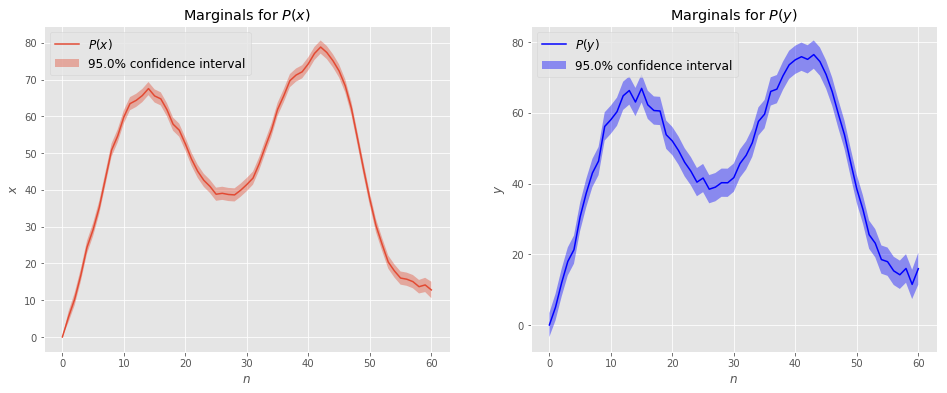

In [85]:
def plot_marginals(x_marginals, y_marginals, alpha=DEFAULT_ALPHA):
    fig = plt.figure(figsize=(16, 6))
    gs = gridspec.GridSpec(1, 2, hspace=0.7)

    n_values = list(range(len(Y)))

    left_ax = plt.subplot(gs[0, 0])
    left_ax.plot(n_values, [x_marginals[i].mean for i in n_values], 
                 label='$P(x)$')
    lower_x, upper_x = zip(*[x.ci(alpha) for x in x_marginals])
    left_ax.fill_between(n_values, lower_x, upper_x, alpha=0.4, 
                         label='{alpha}% confidence interval'.format(alpha=alpha * 100))
    left_ax.set_xlabel('$n$')
    left_ax.set_ylabel('$x$')
    plt.legend(loc=2, fontsize=12)
    plt.title('Marginals for $P(x)$')

    right_ax = plt.subplot(gs[0, 1])
    right_ax.plot(n_values, [y_marginals[i].mean for i in n_values], 
                  label='$P(y)$', color='blue')
    lower_y, upper_y = zip(*[y.ci(alpha) for y in y_marginals])
    right_ax.fill_between(n_values, lower_y, upper_y, alpha=0.4, 
                          facecolor='blue',
                          label='{alpha}% confidence interval'.format(alpha=alpha * 100))
    right_ax.set_xlabel('$n$')
    right_ax.set_ylabel('$y$')
    plt.legend(loc=2, fontsize=12)
    plt.title('Marginals for $P(y)$')

    plt.show()

    
def f_y_to_x(x_i, y_i, var_y):
    if y_i is None or type(y_i) == np.ma.core.MaskedConstant:
        return UnityMessage()
    
    return GaussianMessage(x_i, y_i, var_y)


def inference(y=Y, mean_x=MEAN_X, var_x_0=VAR_X_0, var_x=VAR_X, 
              var_y=VAR_Y, plot_alpha=DEFAULT_ALPHA):
    n = len(y)
    f_y_to_x_messages = [f_y_to_x('x_{i}'.format(i=i), y_i, var_y) 
                         for i, y_i in enumerate(y)]
    
    # Forwards sweep
    # n such messages
    f_x_to_next_x_messages = [GaussianMessage('x_0', mean_x, var_x_0)] 
    # n - 1 such messages, as x_n doesn't send one forwards
    x_to_next_f_x_messages = [] 
    
    for i in range(n - 1):  # TODO: verify this should be n-1
        x_to_next_f_x_messages.append(
            f_x_to_next_x_messages[-1] * f_y_to_x_messages[i])
        factor = GaussianMessage('x_{i}'.format(i=i), 'x_{i}'.format(i=i+1), var_x)
        f_x_to_next_x_messages.append(factor(x_to_next_f_x_messages[-1]))
        
    # Backwards sweep - storing in reverse order, will reverse after computing
    # n such messages
    x_to_previous_f_x_messages = [f_y_to_x_messages[-1]] 
    # n-1 such messages, as f_x_0 doesn't send one backwards, so we append unity
    f_x_to_previous_x_messages = [] 
    
    for i in reversed(range(1, n)): # TODO: verify this should stop at 1
        factor = GaussianMessage('x_{i}'.format(i=i), 'x_{i}'.format(i=i-1), var_x)
        f_x_to_previous_x_messages.append(factor(x_to_previous_f_x_messages[-1]))
        x_to_previous_f_x_messages.append(
            f_x_to_previous_x_messages[-1] * f_y_to_x_messages[i - 1])
        
    x_to_previous_f_x_messages.reverse()
    f_x_to_previous_x_messages.reverse()
    
    # compute messages from x_i to f_y_i
    # hypothetical message from f_x_{n+1} to f_x_n
    f_x_to_previous_x_messages.append(UnityMessage())  
    x_to_f_y_messages = [p * n 
                         for (p, n) 
                         in zip(f_x_to_next_x_messages, 
                                f_x_to_previous_x_messages)]
    
    # compute messages from f_y_i to y_i
    f_y_factors = [GaussianMessage('x_{i}'.format(i=i), 'y_{i}'.format(i=i), var_y) 
                   for i in range(n)]
    f_y_to_y_messages = [x(f) for (x, f) in zip(x_to_f_y_messages, f_y_factors)]
    y_marginals = f_y_to_y_messages
    
    # compute x marginals
    x_marginals = [x_to_f_y * f_y_to_x 
                   for (x_to_f_y, f_y_to_x) 
                   in zip(x_to_f_y_messages, f_y_to_x_messages)]
    
    plot_marginals(x_marginals, y_marginals, plot_alpha)
    
    return x_marginals, y_marginals
    
x_marginals, y_marginals = inference()

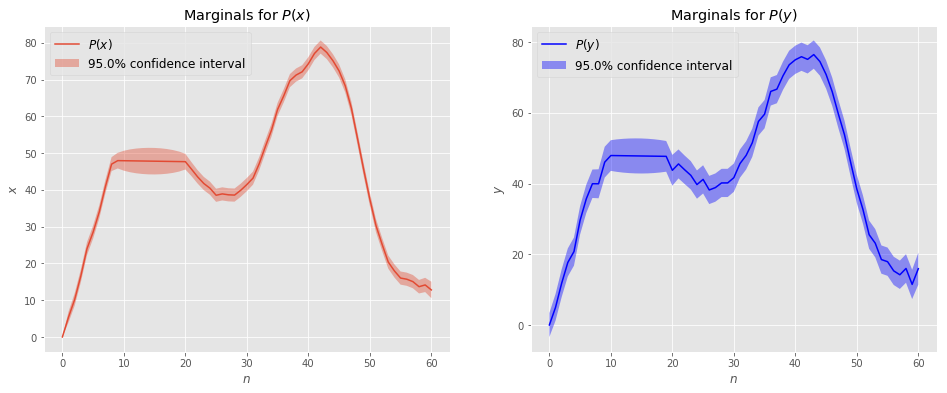

In [88]:
def mask_and_infer(mask_start, mask_end, y=Y, mean_x=MEAN_X, 
                   var_x_0=VAR_X_0, var_x=VAR_X, 
                   var_y=VAR_Y, plot_alpha=DEFAULT_ALPHA):
    n = len(y)
    if mask_start < 0 or mask_start >= n - 1 \
        or mask_end < 0 or mask_end >= n \
        or mask_end <= mask_start:
        raise ValueError('Invalid mask start or end: [{start}, {end})'.format(start=mask_start, end=mask_end))
    
    mask = np.zeros((n,))
    mask[mask_start:mask_end] += 1
    masked_y = np.ma.masked_array(y, mask)
    
    return inference(masked_y, mean_x, var_x_0, var_x, var_y, plot_alpha)
    
masked_x_marginals, masked_y_marginals = mask_and_infer(10, 20)